### sentinel-3 altimetry data processing 

In [38]:
import numpy as np
from glob import glob
import xarray as xr
import geopandas as gpd
from utils.functions import meter2deg
import matplotlib.pyplot as plt
from utils.functions import sample_from_raster, hz01_hz20
from shapely.geometry import Point


In [74]:
path_ht_spahet = 'data/dianchi-lake/swot-pixc/raster_height_spahet.nc'
path_lake_vec = 'data/dianchi-lake/hydrolake_dianchi_edit.gpkg'
paths_s3 = glob('data/dianchi-lake/s3/*/standard_measurement.nc')
path_s3 = paths_s3[0]


In [75]:
## read vector file of the lake.
lake_gdf = gpd.read_file(path_lake_vec)
# ## read geoid correction file
raster_geoid_cor = xr.open_dataset(path_ht_spahet) 
raster_geoid_cor 
## read s3 altimetry data
s3_xr = xr.open_dataset(path_s3)
s3_xr


<xarray.Dataset> Size: 38MB
Dimensions:                                        (time_01: 2019,
                                                    time_20_ku: 40427,
                                                    time_20_c: 39491)
Coordinates:
  * time_01                                        (time_01) datetime64[ns] 16kB ...
  * time_20_ku                                     (time_20_ku) datetime64[ns] 323kB ...
  * time_20_c                                      (time_20_c) datetime64[ns] 316kB ...
    lat_01                                         (time_01) float64 16kB ...
    lon_01                                         (time_01) float64 16kB ...
    lat_20_ku                                      (time_20_ku) float64 323kB ...
    lon_20_ku                                      (time_20_ku) float64 323kB ...
    lat_20_c                                       (time_20_c) float64 316kB ...
    lon_20_c                                       (time_20_c) float64 316kB ...
Data variables: (12/275)
    UTC_day_01                                     (time_01) datetime64[ns] 16kB ...
    UTC_sec_01                                     (time_01) float64 16kB ...
    UTC_day_20_ku                                  (time_20_ku) datetime64[ns] 323kB ...
    UTC_sec_20_ku                                  (time_20_ku) float64 323kB ...
    UTC_day_20_c                                   (time_20_c) datetime64[ns] 316kB ...
    UTC_sec_20_c                                   (time_20_c) float64 316kB ...
    ...                                             ...
    num_20hz_meas_01_ku                            (time_01) float32 8kB ...
    num_20hz_meas_01_c                             (time_01) float32 8kB ...
    orbit_type_01                                  (time_01) float32 8kB ...
    waveform_qual_ice_20_ku                        (time_20_ku) float32 162kB ...
    iono_cor_alt_filtered_01_ku                    (time_01) float64 16kB ...
    iono_cor_alt_filtered_01_plrm_ku               (time_01) float64 16kB ...
Attributes: (12/45)
    Conventions:                       CF-1.6
    title:                             IPF SRAL/MWR Level 2 Measurement
    mission_name:                      Sentinel 3A
    altimeter_sensor_name:             SRAL
    radiometer_sensor_name:            MWR
    gnss_sensor_name:                  GNSS
    ...                                ...
    xref_iono_data:                    S3A_SR_2_RGI_AX_20230728T000000_202307...
    xref_mog2d_data:                   S3__SR_2_RMO_AX_20230728T000000_202307...
    xref_seaice_concentration:         S3__SR_2_SIC_AX_20230728T000000_202307...
    xref_altimeter_ltm:                S3A_SR_1_CA1LAX_20000101T000000_202308...
    xref_doris_uso:                    S3A_SR_1_USO_AX_20160223T195017_202308...
    xref_time_correlation:             S3A_AX___FRO_AX_20230728T000000_202308...

In [76]:
## create a interior buffered lake vector
lake_decrease_gdf = lake_gdf.copy()
lon_center = lake_decrease_gdf.bounds.mean(axis=1).values
utm_zone = np.floor(lon_center/6)+31
epsg_code = f'326{int(utm_zone[0])}'
lake_decrease_gdf = lake_decrease_gdf.to_crs(epsg=epsg_code)
lake_decrease_gdf['geometry'] = lake_decrease_gdf.geometry.buffer(-1000)
lake_decrease_gdf = lake_decrease_gdf.to_crs(epsg=4326)
## select the data within the lake area
points = [Point(lon, lat) for lon, lat in zip(s3_xr['lon_cor_20_ku'].values, s3_xr['lat_cor_20_ku'].values)]
ids_valid_s3 = np.where(lake_decrease_gdf.geometry[0].contains(points))[0]
s3_xr_mask = s3_xr.isel({'time_20_ku': ids_valid_s3})
s3_xr_mask


<xarray.Dataset> Size: 20MB
Dimensions:                                        (time_01: 2019,
                                                    time_20_ku: 54,
                                                    time_20_c: 39491)
Coordinates:
  * time_01                                        (time_01) datetime64[ns] 16kB ...
  * time_20_ku                                     (time_20_ku) datetime64[ns] 432B ...
  * time_20_c                                      (time_20_c) datetime64[ns] 316kB ...
    lat_01                                         (time_01) float64 16kB ...
    lon_01                                         (time_01) float64 16kB ...
    lat_20_ku                                      (time_20_ku) float64 432B ...
    lon_20_ku                                      (time_20_ku) float64 432B ...
    lat_20_c                                       (time_20_c) float64 316kB ...
    lon_20_c                                       (time_20_c) float64 316kB ...
Data variables: (12/275)
    UTC_day_01                                     (time_01) datetime64[ns] 16kB ...
    UTC_sec_01                                     (time_01) float64 16kB ...
    UTC_day_20_ku                                  (time_20_ku) datetime64[ns] 432B ...
    UTC_sec_20_ku                                  (time_20_ku) float64 432B ...
    UTC_day_20_c                                   (time_20_c) datetime64[ns] 316kB ...
    UTC_sec_20_c                                   (time_20_c) float64 316kB ...
    ...                                             ...
    num_20hz_meas_01_ku                            (time_01) float32 8kB ...
    num_20hz_meas_01_c                             (time_01) float32 8kB ...
    orbit_type_01                                  (time_01) float32 8kB ...
    waveform_qual_ice_20_ku                        (time_20_ku) float32 216B ...
    iono_cor_alt_filtered_01_ku                    (time_01) float64 16kB ...
    iono_cor_alt_filtered_01_plrm_ku               (time_01) float64 16kB ...
Attributes: (12/45)
    Conventions:                       CF-1.6
    title:                             IPF SRAL/MWR Level 2 Measurement
    mission_name:                      Sentinel 3A
    altimeter_sensor_name:             SRAL
    radiometer_sensor_name:            MWR
    gnss_sensor_name:                  GNSS
    ...                                ...
    xref_iono_data:                    S3A_SR_2_RGI_AX_20230728T000000_202307...
    xref_mog2d_data:                   S3__SR_2_RMO_AX_20230728T000000_202307...
    xref_seaice_concentration:         S3__SR_2_SIC_AX_20230728T000000_202307...
    xref_altimeter_ltm:                S3A_SR_1_CA1LAX_20000101T000000_202308...
    xref_doris_uso:                    S3A_SR_1_USO_AX_20160223T195017_202308...
    xref_time_correlation:             S3A_AX___FRO_AX_20230728T000000_202308...

In [77]:
## 1. geophysical correction by refering to official document.
geo_corr_01hz=['mod_dry_tropo_cor_meas_altitude_01', 'mod_wet_tropo_cor_meas_altitude_01', 
                                        'iono_cor_gim_01_ku', 'load_tide_sol1_01', 
                                        'solid_earth_tide_01', 'pole_tide_01']
s3_geophy_01hz = 0
for cor_01hz_name in geo_corr_01hz:
  s3_geophy_01hz += s3_xr_mask[cor_01hz_name].values

## 2. Resample the 1Hz variables to 20Hz variables
times_20, times_01 = s3_xr_mask['time_20_ku'].values, s3_xr_mask['time_01'].values
s3_geophy_20hz = hz01_hz20(data_01hz=s3_geophy_01hz, time_01hz=times_01, time_20hz=times_20)
## 3. Calculate the corrected surface water height
## 3.1 ocog/ocean retracker
height_ocog = s3_xr_mask['alt_20_ku'].values - s3_xr_mask['range_ocog_20_ku'].values - s3_geophy_20hz ## height_ellip


Text(0.5, 1.0, 'pixc Geoid')

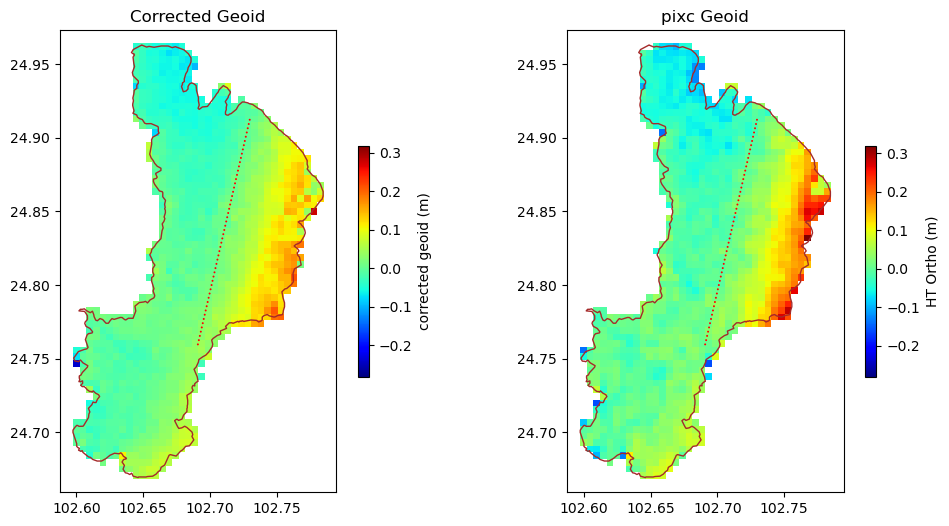

In [78]:
extent_raster = [raster_geoid_cor.x.min(), raster_geoid_cor.x.max(),
           raster_geoid_cor.y.min(), raster_geoid_cor.y.max()]
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
geoid_mean = np.nanmean(raster_geoid_cor.ht_spahet_smoothed.values)
img_show1 = ax[0].imshow(raster_geoid_cor.ht_spahet_smoothed.values, cmap='jet', 
                        vmin = geoid_mean-0.3, vmax = geoid_mean+0.3, extent=extent_raster)
lake_gdf.plot(ax=ax[0], edgecolor='Brown', facecolor='none', linewidth=1)
scat1 = ax[0].scatter(x=s3_xr_mask['lon_20_ku'].values, y=s3_xr_mask['lat_20_ku'].values,
                      c='red', s=2, edgecolor='none')
plt.colorbar(img_show1, ax=ax[0], label='corrected geoid (m)', shrink=0.5)
ax[0].set_title('Corrected Geoid')
geoid_mean = np.nanmean(raster_geoid_cor.geoid_spahet.values)
img_show2 = ax[1].imshow(raster_geoid_cor.geoid_spahet.values, cmap='jet', 
                         vmin = geoid_mean-0.3, vmax = geoid_mean+0.3,
                         extent=extent_raster)
lake_gdf.plot(ax=ax[1], edgecolor='Brown', facecolor='none', linewidth=1)
scat2 = ax[1].scatter(x=s3_xr_mask['lon_20_ku'].values, y=s3_xr_mask['lat_20_ku'].values,
                      c='red', s=2, edgecolor='none')
plt.colorbar(img_show2, ax=ax[1], label='HT Ortho (m)', shrink=0.5)
ax[1].set_title('pixc Geoid')



In [ ]:
## geoid correction
## sample the geoid correction raster to the S3 points
s3_ht_spahet = sample_from_raster(
        raster_value=raster_geoid_cor.ht_spahet_smoothed.values,
        raster_x = raster_geoid_cor.x.values,
        raster_y = raster_geoid_cor.y.values,
        points_x = s3_xr_mask['lon_20_ku'],
        points_y = s3_xr_mask['lat_20_ku']
)

s3_geoid_20hz = hz01_hz20(data_01hz=s3_xr_mask['geoid_01'].values, time_01hz=times_01, time_20hz=times_20)
s3_ht_ortho = height_ocog - s3_geoid_20hz  ## 
s3_geoid_cor = np.nanmean(s3_geoid_20hz) + s3_ht_spahet
s3_ht_ortho_cor = height_ocog - s3_geoid_cor


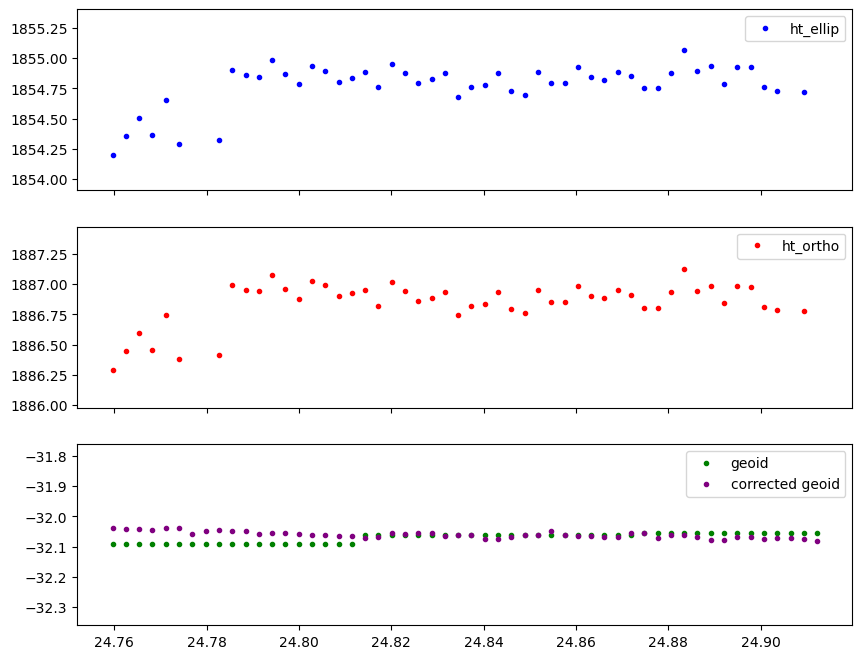

In [80]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
## plot height_ellip
ht_mean = np.mean(height_ocog)
ax[0].plot(s3_xr_mask['lat_20_ku'], height_ocog, 
         marker='o', markersize=3, linestyle='None', 
         color='blue', label='ht_ellip')
ax[0].set_ylim(ht_mean - 0.5, ht_mean + 1)
ax[0].legend()
## plot height_ortho
ht_ortho_mean = np.nanmean(s3_ht_ortho)
ax[1].plot(s3_xr_mask['lat_20_ku'], s3_ht_ortho, 
         marker='o', markersize=3, linestyle='None', 
         color='red', label='ht_ortho')
ax[1].set_ylim(ht_ortho_mean - 0.5, ht_ortho_mean + 1)
ax[1].legend()
## plot geoid
s3_geoid_mean = np.nanmean(s3_geoid_20hz)
ax[2].plot(s3_xr_mask['lat_20_ku'], s3_geoid_20hz, 
         marker='o', markersize=3, linestyle='None', 
         color='green', label='geoid')
ax[2].set_ylim(s3_geoid_mean - 0.3, s3_geoid_mean + 0.3)
## plot corrected geoid
s3_geoid_cor_mean = np.nanmean(s3_geoid_cor)
ax[2].plot(s3_xr_mask['lat_20_ku'], s3_geoid_cor,
         marker='o', markersize=3, linestyle='None', 
         color='purple', label='corrected geoid')
ax[2].set_ylim(s3_geoid_cor_mean - 0.3, s3_geoid_cor_mean + 0.3)
ax[2].legend()


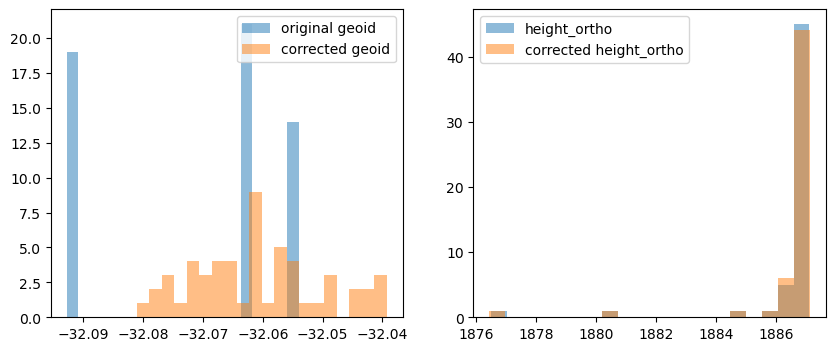

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(s3_geoid_20hz, bins=20, alpha=0.5, label='original geoid');
ax[0].hist(s3_geoid_cor.ravel(), bins=20, alpha=0.5, label='corrected geoid');
ax[0].legend();
ax[1].hist(s3_ht_ortho, bins=20, alpha=0.5, label='height_ortho');
ax[1].hist(s3_ht_ortho_cor, bins=20, alpha=0.5, label='corrected height_ortho');
ax[1].legend();


In [83]:
s3_ht_ds = xr.Dataset({
  "geoid": (["time_20_ku"], s3_geoid_20hz),
  "geoid_cor": (["time_20_ku"], s3_geoid_cor),  
  "ht_ortho": (["time_20_ku"], s3_ht_ortho),
  "ht_ortho_cor": (["time_20_ku"], s3_ht_ortho_cor)
}, coords={
  "time_20_ku": s3_xr_mask["time_20_ku"],
  "lon_20_ku": s3_xr_mask["lon_20_ku"],
  "lat_20_ku": s3_xr_mask["lat_20_ku"]
})

path_save = path_s3.replace('.h5', '_height.nc')
# s3_ht_ds.to_netcdf(path_save)
s3_ht_ds


<xarray.Dataset> Size: 3kB
Dimensions:       (time_20_ku: 54)
Coordinates:
  * time_20_ku    (time_20_ku) datetime64[ns] 432B 2023-07-28T03:25:17.821470...
    lat_20_ku     (time_20_ku) float64 432B 24.91 24.91 24.91 ... 24.76 24.76
    lon_20_ku     (time_20_ku) float64 432B 102.7 102.7 102.7 ... 102.7 102.7
Data variables:
    geoid         (time_20_ku) float64 432B -32.05 -32.05 ... -32.09 -32.09
    geoid_cor     (time_20_ku) float64 432B -32.08 -32.07 ... -32.04 -32.04
    ht_ortho      (time_20_ku) float64 432B 1.886e+03 1.887e+03 ... 1.886e+03
    ht_ortho_cor  (time_20_ku) float64 432B 1.886e+03 1.887e+03 ... 1.886e+03

In [84]:
print('std of geoid height:          ', np.nanstd(s3_ht_ds['ht_ortho']))
print('std of geoid height corrected:', np.nanstd(s3_ht_ds['ht_ortho_cor']))


std of geoid height:           1.6693614489085868
std of geoid height corrected: 1.6725419668603685


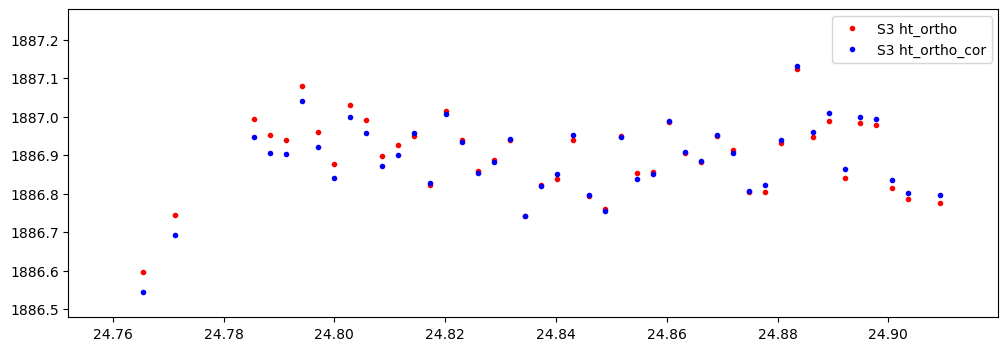

In [86]:
height_geoid_median = np.nanmedian(s3_ht_ds['ht_ortho'])
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(s3_xr_mask['lat_20_ku'], s3_ht_ds['ht_ortho'], 
                  marker='o', markersize=3, linestyle='None', 
                  color='red', label='S3 ht_ortho')

ax.plot(s3_xr_mask['lat_20_ku'], s3_ht_ds['ht_ortho_cor'], 
                  marker='o', markersize=3, linestyle='None', 
                  color='blue', label='S3 ht_ortho_cor')
ax.set_ylim(height_geoid_median-0.4, height_geoid_median+0.4)
ax.legend()
